In [106]:
# Torchvision Data
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, transforms

# Other Python Libraries
import matplotlib.pyplot as plt
import numpy as np

# torch related libraries
import torch
from torch import nn
from torch.utils.data import DataLoader, ConcatDataset
import torch.nn.functional as F

# Use tqdm
from tqdm import tqdm

# Define accuracy function for torch training
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

# helper function to predict image class
def show_predict_digit(model, dataset, index):
    image_tensor = dataset.data[index].unsqueeze(0).unsqueeze(0).to(torch.float32)
    plt.figure(figsize=(4, 4))
    plt.imshow(image_tensor.squeeze(0).squeeze(0))
    
    with torch.no_grad():
        output = model(image_tensor)
    
    return torch.argmax(output)


In this notebook, we are going to train our first instance of a Computer Vision algorithm on the famous [MNIST Dataset](https://en.wikipedia.org/wiki/MNIST_database). This will be used as our first example on how to train a computer vision algorithm from scratch using *pytorch*.

We'll start by loading the dataset below with some transformations for standardization:

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load training and test datasets
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)


Training data contains around 60000 images that we can classify into some categories. But before we check the images, let's create our train and test *torch* loaders!

Example of the tensors we've generated:

In [3]:
image, label = train_dataset[0]
image

tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1

What's the shape of our tensor?

In [4]:
image.shape

torch.Size([1, 28, 28])

Let's check some examples of our data:

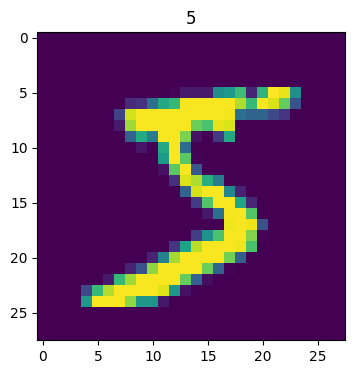

In [5]:
image, label = train_dataset[0]
image = np.transpose(image, (1, 2, 0))

plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.title(label);

The number 5!

Another example:

torch.Size([1, 28, 28])


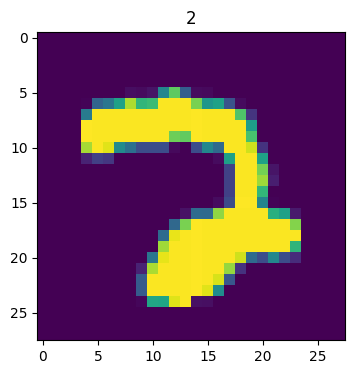

In [38]:
image, label = train_dataset[120]
image = np.transpose(image, (1, 2, 0))

plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.title(label);

Number 2!

I think you get the hand of it - our goal is to use a `torch` model to classify our images - we'll start by defining our data in batches as we've said. We'll use the batches of 3 we've set using `torch loaders`. We'll use a batch size of 30:

In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=30, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=30)

In [8]:
print(f"Dataloaders: {train_loader, test_loader}")
print(f"Length of train dataloader: {len(train_loader)} batches of {train_loader.batch_size}")
print(f"Length of test dataloader: {len(test_loader)} batches of {train_loader.batch_size}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x0000023F31159110>, <torch.utils.data.dataloader.DataLoader object at 0x0000023F311EA910>)
Length of train dataloader: 2000 batches of 30
Length of test dataloader: 334 batches of 30


In [9]:
train_features_batch, train_labels_batch = next(iter(train_loader))
train_features_batch.shape

torch.Size([30, 1, 28, 28])

An example of the labels we want to classify in our batch:

In [10]:
train_labels_batch

tensor([4, 4, 7, 6, 0, 7, 1, 3, 2, 2, 8, 1, 2, 9, 7, 3, 0, 6, 5, 4, 4, 6, 1, 0,
        4, 6, 4, 4, 2, 5])

Our class names are the following:

In [11]:
class_names = train_dataset.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

### Training a Feed Forward Model

According to our last lectures, we've seen how to create models using non-linearities. Let's try to do that first:

In [12]:
class MNIST_NN(nn.Module):
    def __init__(self, input_shape: int, 
                 hidden_units: int, 
                 output_shape: int):
        super().__init__()
        
        # Create a hidden layer with non-linearities
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

Let's instantiate our model:

In [13]:
model_non_linear = MNIST_NN(input_shape=28*28,
    hidden_units=150,
    output_shape=len(class_names))

# Loss and optimizer are defined next
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_non_linear.parameters(),
                            lr=0.01)

Finally, we can define training and test steps for our Neural Network:

In [14]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn):
    
    # Zero loss and acc
    train_loss, train_acc = 0, 0
    
    model.train()
    
    for batch, (X, y) in enumerate(data_loader):

        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.2f} | Train accuracy: {train_acc:.2f}%")

    return train_loss

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn):
    test_loss, test_acc = 0, 0
    model.eval() 
    
    with torch.no_grad(): 
        for X, y in data_loader:
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y).item() 
            test_acc += accuracy_fn(y_true=y,
                                    y_pred=test_pred.argmax(dim=1))

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

        return test_loss


Let's train our MNIST model for 10 epochs!

In [15]:
loss_hist = {}

# Setup train and test loss history
loss_hist['train'] = {}
loss_hist['test'] = {}

epochs = 10
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_loss = train_step(data_loader=train_loader,
        model=model_non_linear,
        loss_fn=loss_function,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )

    loss_hist['train'][epoch] = train_loss

    test_loss = test_step(data_loader=test_loader,
        model=model_non_linear,
        loss_fn=loss_function,
        accuracy_fn=accuracy_fn
    )

    loss_hist['test'][epoch] = test_loss

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.00 | Train accuracy: 68.55%


 10%|████████▎                                                                          | 1/10 [00:15<02:15, 15.04s/it]

Test loss: 0.76031 | Test accuracy: 73.91%

Epoch: 1
---------
Train loss: 0.75 | Train accuracy: 73.72%


 20%|████████████████▌                                                                  | 2/10 [00:30<02:04, 15.50s/it]

Test loss: 0.71039 | Test accuracy: 74.90%

Epoch: 2
---------
Train loss: 0.71 | Train accuracy: 74.67%


 30%|████████████████████████▉                                                          | 3/10 [00:50<02:01, 17.34s/it]

Test loss: 0.68952 | Test accuracy: 75.32%

Epoch: 3
---------
Train loss: 0.68 | Train accuracy: 75.42%


 40%|█████████████████████████████████▏                                                 | 4/10 [01:09<01:48, 18.05s/it]

Test loss: 0.66074 | Test accuracy: 76.13%

Epoch: 4
---------
Train loss: 0.66 | Train accuracy: 76.04%


 50%|█████████████████████████████████████████▌                                         | 5/10 [01:27<01:29, 17.90s/it]

Test loss: 0.63752 | Test accuracy: 76.45%

Epoch: 5
---------
Train loss: 0.64 | Train accuracy: 76.53%


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [01:44<01:10, 17.75s/it]

Test loss: 0.62235 | Test accuracy: 76.97%

Epoch: 6
---------
Train loss: 0.62 | Train accuracy: 76.92%


 70%|██████████████████████████████████████████████████████████                         | 7/10 [02:03<00:54, 18.03s/it]

Test loss: 0.61299 | Test accuracy: 77.03%

Epoch: 7
---------
Train loss: 0.61 | Train accuracy: 77.21%


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [02:20<00:35, 17.89s/it]

Test loss: 0.59648 | Test accuracy: 77.41%

Epoch: 8
---------
Train loss: 0.45 | Train accuracy: 84.05%


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [02:39<00:18, 18.19s/it]

Test loss: 0.38133 | Test accuracy: 86.55%

Epoch: 9
---------
Train loss: 0.37 | Train accuracy: 86.99%


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:59<00:00, 17.90s/it]

Test loss: 0.36962 | Test accuracy: 86.81%



Model converged in an interesting way:

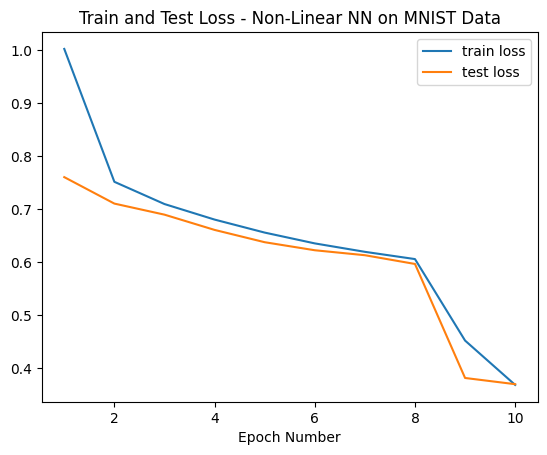

In [17]:
train_loss_hist = [loss_hist['train'][val] for val in loss_hist['train']]
test_loss_hist = [loss_hist['test'][val] for val in loss_hist['test']]

plt.plot(np.arange(1,11), train_loss_hist)
plt.plot(np.arange(1,11), test_loss_hist)

plt.title('Train and Test Loss - Non-Linear NN on MNIST Data')
plt.legend(['train loss','test loss'])
plt.xlabel('Epoch Number')
plt.show()

Let's see how our neural network is classifying our digits on the test set:

tensor(7)

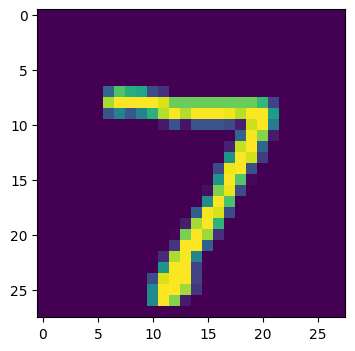

In [107]:
show_predict_digit(model_non_linear,
                  test_dataset,
                  0)

tensor(0)

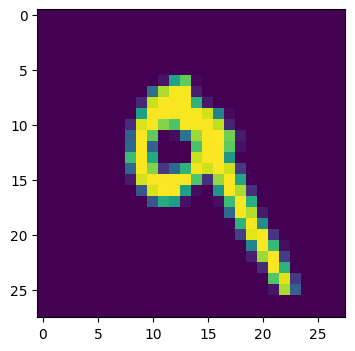

In [108]:
show_predict_digit(model_non_linear,
                  test_dataset,
                  7)

Let's now try to fit a Convolutional Neural Network using `PyTorch`:

In [88]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, 
                               kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5) 
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.batch_norm2 = nn.BatchNorm2d(64)

    def forward(self, x):
        x = self.pool(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool(F.relu(self.batch_norm2(self.conv2(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

net = SimpleCNN()

Pay attention to the learning rate when creating a CNN! Vanishing or Exploding gradients may enter into play and make your network not converge.

In [89]:
optimizer = torch.optim.SGD(params=net.parameters(),
                            lr=0.05)

And training our CNN:

In [91]:
loss_hist_cnn = {}

loss_hist_cnn['train'] = {}
loss_hist_cnn['test'] = {}

epochs = 10
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    loss_cnn = train_step(data_loader=train_loader,
        model=net,
        loss_fn=loss_function,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )

    loss_hist_cnn['train'][epoch] = loss_cnn

    loss_cnn_test = test_step(data_loader=test_loader,
        model=net,
        loss_fn=loss_function,
        accuracy_fn=accuracy_fn
    )

    loss_hist_cnn['test'][epoch] = loss_cnn_test

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.28 | Train accuracy: 91.07%


 10%|████████▏                                                                         | 1/10 [03:04<27:43, 184.85s/it]

Test loss: 0.05675 | Test accuracy: 98.18%

Epoch: 1
---------
Train loss: 0.11 | Train accuracy: 96.58%


 20%|████████████████▍                                                                 | 2/10 [05:52<23:17, 174.68s/it]

Test loss: 0.04276 | Test accuracy: 98.62%

Epoch: 2
---------
Train loss: 0.09 | Train accuracy: 97.34%


 30%|████████████████████████▌                                                         | 3/10 [08:36<19:50, 170.04s/it]

Test loss: 0.04229 | Test accuracy: 98.62%

Epoch: 3
---------
Train loss: 0.07 | Train accuracy: 97.82%


 40%|████████████████████████████████▊                                                 | 4/10 [11:23<16:52, 168.69s/it]

Test loss: 0.03385 | Test accuracy: 98.84%

Epoch: 4
---------
Train loss: 0.06 | Train accuracy: 98.17%


 50%|█████████████████████████████████████████                                         | 5/10 [14:13<14:06, 169.24s/it]

Test loss: 0.03780 | Test accuracy: 98.85%

Epoch: 5
---------
Train loss: 0.05 | Train accuracy: 98.40%


 60%|█████████████████████████████████████████████████▏                                | 6/10 [17:03<11:17, 169.25s/it]

Test loss: 0.03176 | Test accuracy: 99.03%

Epoch: 6
---------
Train loss: 0.05 | Train accuracy: 98.54%


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [19:47<08:22, 167.57s/it]

Test loss: 0.02851 | Test accuracy: 99.10%

Epoch: 7
---------
Train loss: 0.04 | Train accuracy: 98.72%


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [22:50<05:44, 172.47s/it]

Test loss: 0.02403 | Test accuracy: 99.21%

Epoch: 8
---------
Train loss: 0.04 | Train accuracy: 98.86%


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [25:34<02:49, 169.81s/it]

Test loss: 0.02303 | Test accuracy: 99.28%

Epoch: 9
---------
Train loss: 0.04 | Train accuracy: 98.94%


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [28:09<00:00, 168.97s/it]

Test loss: 0.02511 | Test accuracy: 99.28%



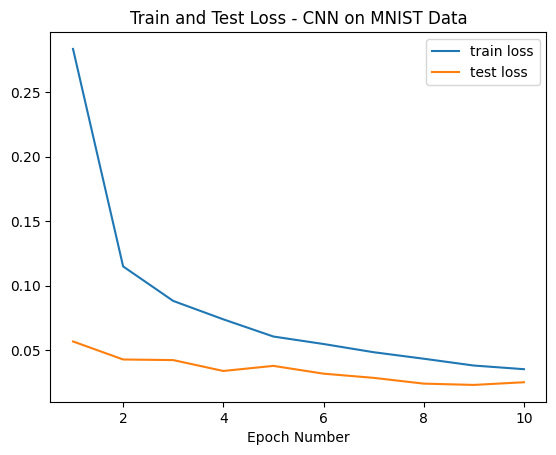

In [97]:
train_loss_hist_cnn = [loss_hist_cnn['train'][val] for val in loss_hist_cnn['train']]
test_loss_hist_cnn = [loss_hist_cnn['test'][val] for val in loss_hist_cnn['test']]

plt.plot(np.arange(1,11), train_loss_hist_cnn)
plt.plot(np.arange(1,11), test_loss_hist_cnn)

plt.title('Train and Test Loss - CNN on MNIST Data')
plt.legend(['train loss','test loss'])
plt.xlabel('Epoch Number')
plt.show()

tensor(9)

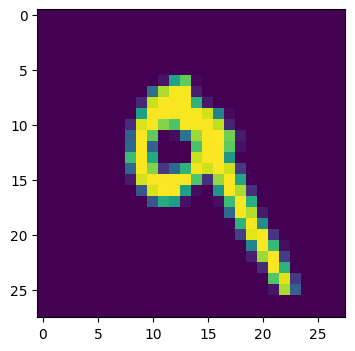

In [109]:
show_predict_digit_cnn(net,
                  test_dataset,
                  7)

tensor(5)

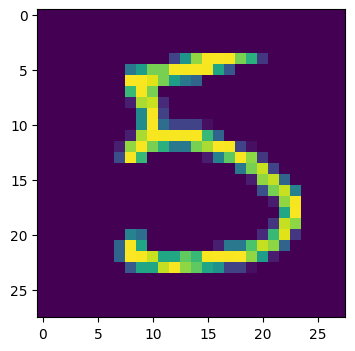

In [111]:
show_predict_digit_cnn(net,
                  test_dataset,
                  15)